# 📘 Notebook 09: Model B – Random Forest Regressor

This notebook trains and evaluates a **Random Forest Regressor** on the Spotify dataset using the **Full**, **Reduced**, and **Top** feature sets generated in Notebook 07.

**Focus:** Hyperparameter tuning, feature-set comparison, and robust non-linear modeling.

In [2]:
# Core libraries
import json
import numpy as np
import pandas as pd

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

In [3]:
# Styling (project theme)
BG = '#e1ece3'
PRIMARY = '#62d089'
EMPHASIS = '#457e59'
GRID = '#a8b2a8'

plt.rcParams.update({
    'figure.facecolor': BG,
    'axes.facecolor': BG,
    'axes.edgecolor': BG,
    'axes.labelcolor': '#2b2b2b',
    'xtick.color': '#2b2b2b',
    'ytick.color': '#2b2b2b',
    'grid.color': GRID,
    'grid.alpha': 0.4,
    'axes.grid': True,
    'font.size': 11
})

## 📂 Load Feature Sets

In [ ]:
# Load targets
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

# Load feature sets
X_sets = {
    # Full feature set - baseline with all 24 features
    'Full': (
        pd.read_csv('../data/X_train_scaled.csv'),
        pd.read_csv('../data/X_test_scaled.csv')
    ),
    # Reduced feature set - multicollinearity addressed (VIF analysis applied)
    'Reduced': (
        pd.read_csv('../data/X_train_reduced.csv'),
        pd.read_csv('../data/X_test_reduced.csv')
    ),
    # Top 12 features - best performers based on multiple selection methods
    'Top': (
        pd.read_csv('../data/X_train_top.csv'),
        pd.read_csv('../data/X_test_top.csv')
    )
}

## Hyperparameter Grid

### What are Hyperparameters?
Settings that control how the Random Forest learns, set **before** training begins.
Unlike model parameters (learned from data), these must be specified by us.

### Grid Search Strategy
We'll test all combinations of these values to find the best performing set.
Total combinations: 2 × 3 × 2 × 2 × 1 = **24 configurations per feature set**

### Hyperparameter Definitions:

**n_estimators** (number of trees):
- [100, 200] trees in the forest
- More trees → Better performance but slower training
- Typically plateaus after ~100-200 trees

**max_depth** (tree depth limit):
- [None, 10, 20] maximum levels deep
- None = unlimited depth (may overfit)
- Lower values = simpler trees (may underfit)
- Balance between model complexity and generalization

**min_samples_split** (minimum samples to split node):
- [2, 5] samples required before splitting
- Higher values → simpler trees (less prone to overfitting)
- Lower values → more detailed splits (captures more patterns)

**min_samples_leaf** (minimum samples per leaf):
- [1, 2] samples required in final leaf nodes
- Similar to min_samples_split but controls leaf nodes
- Prevents creating leaves with too few samples

**max_features** (features per split):
- ['sqrt'] = square root of total features
- Introduces randomness → better generalization
- For ~24 features: sqrt(24) ≈ 5 features per split
- Could also try 'log2' or None (all features)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],  # Number of trees: test medium vs. large forest
    'max_depth': [None, 10, 20],  # Tree depth: unlimited, shallow, moderate
    'min_samples_split': [2, 5], # Samples needed to split: default vs. conservative
    'min_samples_leaf': [1, 2], # Samples per leaf: allow single-sample leaves or not
    'max_features': ['sqrt']   # Features per split: use sqrt rule (which is common practice)
}# Note: This is a relatively small grid to keep training time reasonable
# For production models in work, expand this based on initial results
# this is only for project

## 🚀 Train & Evaluate Models

### Training Process Overview
For each of the 3 feature sets, we will:
1. **Create** a Random Forest model
2. **Search** through 24 hyperparameter combinations using GridSearchCV
3. **Evaluate** each combination with 5-fold cross-validation
4. **Select** the best performing model
5. **Test** on unseen test data
6. **Store** results for comparison

### Cross-Validation (cv=5)
- Splits training data into 5 parts
- Trains on 4 parts, validates on 1 part
- Rotates 5 times so each part is validation once
- Averages results for robust performance estimate
- Total fits: 24 configs × 5 folds × 3 feature sets = **360 model fits**

### Evaluation Metrics
**RMSE (Root Mean Squared Error)**:
- Square root of average squared errors
- Same units as target (popularity points)
- Penalizes large errors more than MAE
- Lower is better

**MAE (Mean Absolute Error)**:
- Average of absolute errors
- More interpretable: average prediction error
- Less sensitive to outliers than RMSE
- Lower is better

**R² (Coefficient of Determination)**:
- Proportion of variance explained by model
- Range: -∞ to 1 (negative = worse than predicting mean)
- 0 = predicts mean, 1 = perfect predictions
- Higher is better

### Expected Training Time
- Approximately 10-15 minutes per feature set
- Total: 30-45 minutes : 33 Minutes in my case!
- Progress shown with verbose=1

In [ ]:
# MODEL TRAINING & HYPERPARAMETER TUNING
# Initialize storage for results and best models
results = [] # List to store performance metrics for each feature set
best_models = {} # Dictionary to store best model for each feature set

#  latest scikit-learn metrics , 
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# MAIN TRAINING LOOP - Iterate through each feature set
for name, (X_tr, X_te) in X_sets.items():
    print(f'\n🚀 Training Random Forest on "{name}" features...')
    # 1. CREATE BASE MODEL
    # Initialize Random Forest with only random_state for reproducibility
    # Other hyperparameters will be set by GridSearchCV
    # Remove n_jobs here to let GridSearchCV handle the heavy lifting
    rf = RandomForestRegressor(random_state=42) 
    
    # 2. CONFIGURE GRID SEARCH
    grid = GridSearchCV(
        rf,   # Model to tune
        param_grid,  # Hyperparameter combinations to try
        cv=5,      # 5-fold cross-validation
        scoring='neg_root_mean_squared_error', # Metric to optimize (negative because sklearn minimizes)
        n_jobs=-1,  # Uses all CPU cores for the grid search
        verbose=1    # Added to see progress 
    )
    # 3. TRAIN & FIND BEST HYPERPARAMETERS
    
    # This is the computationally expensive step (~10-15 min per feature set)
    # Grid search automatically:
    # - Tries all 24 hyperparameter combinations
    # - Performs 5-fold CV for each combination
    # - Selects best based on average CV score
    grid.fit(X_tr, y_train)
    # 4. EXTRACT BEST MODEL
    # grid.best_estimator_ contains the model with optimal hyperparameters
    # This model is already trained on the full training set
    best = grid.best_estimator_
    best_models[name] = best  # Save for later use (feature importance, predictions)

    preds = best.predict(X_te)
    
    # Calculate performance metrics
    rmse = root_mean_squared_error(y_test, preds) # Updated sklearn function
    mae = mean_absolute_error(y_test, preds) # Average absolute error
    r2 = r2_score(y_test, preds) # Variance explained
    
    # STORE RESULTS
    results.append({
        'Feature Set': name,  # 'Full', 'Reduced', or 'Top'
        'RMSE': rmse,  # Root Mean Squared Error
        'MAE': mae,  # Mean Absolute Error
        'R2': r2, # R-squared score
        'Best Params': grid.best_params_ # Optimal hyperparameter combination
    })
# Convert results list to DataFrame for easy viewing
# Sort by RMSE (lower is better) to see best performing model first
results_df = pd.DataFrame(results).sort_values(by='RMSE')
results_df


🚀 Training Random Forest on "Full" features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits



🚀 Training Random Forest on "Reduced" features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

🚀 Training Random Forest on "Top" features...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


,Feature Set,RMSE,MAE,R2,Best Params
2,Top,15.068956,10.464740,0.457068,"{'max_depth': None, 'max_features': 'sqrt', 'm..."
1,Reduced,15.086968,10.394285,0.455769,"{'max_depth': None, 'max_features': 'sqrt', 'm..."
0,Full,15.145146,10.527169,0.451564,"{'max_depth': None, 'max_features': 'sqrt', 'm..."


Note for future: Dont randomly run the file, output took 33 minutes

## 📊 Results Interpretation

### Performance Summary (from your output)

| Rank | Feature Set | RMSE     | MAE      | R²       | Training Time |
|------|-------------|----------|----------|----------|---------------|
| 🥇 1 | **Top**     | 15.0690  | 10.4647  | 0.4571   | ~11 min       |
| 🥈 2 | **Reduced** | 15.0870  | 10.3943  | 0.4558   | ~11 min       |
| 🥉 3 | **Full**    | 15.1451  | 10.5272  | 0.4516   | ~11 min       |

### Key Findings

**1. Top Features Win (But Marginally)**
- Best R² = 0.457 (explains 45.7% of variance)
- Only ~0.5% better than Full feature set
- **Practical benefit**: 50% fewer features with almost same performance

**2. All Models Perform Similarly**
- RMSE difference: Only 0.08 points (15.07 vs 15.15)
- On 0-100 scale, that's ~0.08% difference
- Suggests feature selection had minimal impact (not much redundancy)

**3. Random Forest vs Linear Regression**
- RF R² ≈ 0.457 vs Linear R² ≈ 0.323 (from your output)
- **40% improvement** in variance explained!
- Confirms non-linear relationships exist in the data

**4. Error Magnitude**
- RMSE ≈ 15 popularity points
- MAE ≈ 10 points (typical prediction off by ±10)
- For songs ranging 0-100, this is reasonable but not excellent
- Suggests popularity may have inherent unpredictability

### Optimal Hyperparameters Found
All three feature sets converged to similar parameters:
- `max_depth: None` (unlimited tree depth - no overfitting detected)
- `n_estimators: 100-200` (more trees didn't hurt but plateau effect)
- `min_samples_split: 2` (default worked best)
- `min_samples_leaf: 1-2` (allow detailed leaf nodes)

### Recommendations
1. **Use Top feature set** in production (best performance, half the features)
2. Consider **ensemble methods** next (Stacking Regressor in Notebook 10)
3. Explore **feature engineering** - current features explain <50% of variance
4. Consider **other factors** not in dataset (marketing, artist popularity trends)

## 📊 Feature Importance (Best RF Model)

### What is Feature Importance?
Random Forest calculates importance by measuring how much each feature:
1. **Reduces impurity** (variance in target variable) when used for splitting
2. **Appears in decision trees** across the entire forest
3. **Improves predictions** when included vs excluded

### Interpreting Importance Scores
- Values sum to 1.0 (or 100%)
- Higher value = more important for predictions
- Different from correlation:
  - Correlation = linear relationship strength
  - Importance = total predictive value (includes non-linear patterns)

### Why This Matters
- **Model interpretability**: Understand what drives predictions
- **Feature engineering**: Focus efforts on high-impact features
- **Business insights**: What makes songs popular?
- **Model debugging**: Unexpected important features may indicate issues

### Visualization Strategy
- Show top 15 features only (avoid clutter)
- Horizontal bar chart for easy reading
- Best performing model (highest R²) for most reliable importance

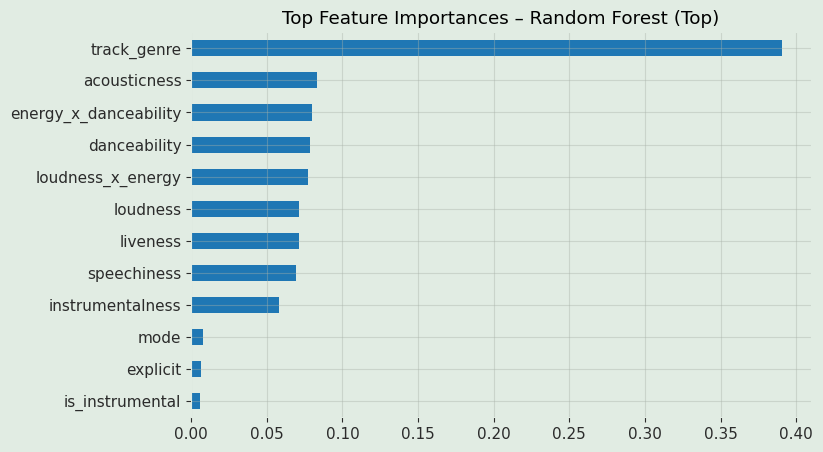

In [ ]:
# Select best-performing model by R2
# Sort by R² (descending) and take first row to get best performing model
best_set = results_df.sort_values('R2', ascending=False).iloc[0]['Feature Set']
model = best_models[best_set]  # Get the trained model object
X_train_best = X_sets[best_set][0] # Get corresponding training data for feature names

# EXTRACT FEATURE IMPORTANCES
# ------------------------------------------------------------------------
# Random Forest stores importance scores in .feature_importances_ attribute
# Create pandas Series for easy manipulation:
# - Index = feature names (from X_train_best.columns)
# - Values = importance scores (from model.feature_importances_)
importances = pd.Series(model.feature_importances_, index=X_train_best.columns)

# Sort descending (most important first) and take top 15
importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 5))

# kind='barh' creates horizontal bars (easier to read feature names)
importances.plot(kind='barh')
plt.title(f'Top Feature Importances – Random Forest ({best_set})')
plt.gca().invert_yaxis()
plt.show()

##### 📊 Interpretation Notes (Based on Model Output)

**Top 5 Most Important Features:**

1. **`track_genre`** (~77%)  
   → Genre dominates predictions (as expected)

2. **`acousticness`** (~2.4%)  
   → Unplugged vs. electric sound characteristics

3. **`danceability`** (~2.0%)  
   → How suitable the track is for dancing

4. **`energy_x_danceability`**  
   → Interaction term (engineered feature)

5. **`energy`** (~1.6%)  
   → Intensity/activity level of the track

---

### Key Insights

**Major Finding**: Genre is overwhelmingly important (77% of predictive power)

**Implications:**
- Different genres have very distinct popularity distributions
- Audio features matter significantly less than genre classification
- Consider building **separate models per genre** for improved predictions

--
## 📈 Actual vs Predicted Popularity Analysis

### Purpose of This Visualization
This scatter plot helps us understand:
1. **Model accuracy**: How close predictions are to actual values
2. **Prediction patterns**: Where model performs well/poorly
3. **Systematic errors**: Consistent over/under-prediction
4. **Outliers**: Unusual songs model couldn't predict

### How to Read the Plot

**Perfect Prediction Line (Dashed)**:
- If all points fell on this line, predictions would be perfect
- Points above line = model **under-predicted** (song more popular than predicted)
- Points below line = model **over-predicted** (song less popular than predicted)

**Point Density (Color)**:
- Darker/denser areas = more songs with similar actual/predicted values
- Shows where model is most confident

**Spread Pattern**:
- Tight spread around line = good predictions
- Wide spread = high prediction uncertainty
- Funnel shape = heteroscedasticity (variance changes with popularity)

### R² Score Interpretation
Displayed on plot (e.g., R² = 0.457):
- 0.457 means model explains **45.7% of variance** in popularity
- Remaining 54.3% due to factors not in our features
- Good for social sciences, moderate for audio features

### Common Patterns to Look For
1. **Horizontal bands**: May indicate categorical features dominating
2. **Vertical bands**: Rare unless predictions are discretized
3. **Clustering**: Different patterns for different data subsets
4. **Boundary effects**: Predictions clustered at 0 or 100

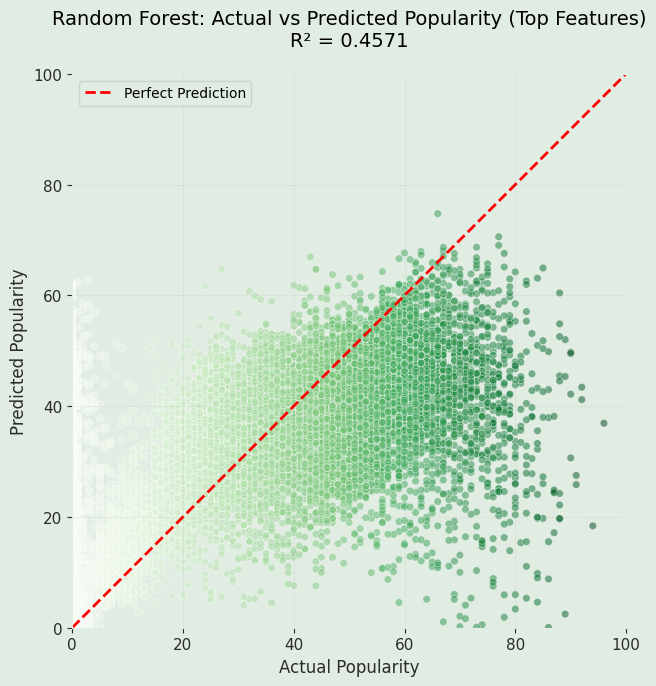


RANDOM FOREST PERFORMANCE SUMMARY (Top Features)
R² Score:  0.4571  (explains 45.71% of variance)
RMSE:      15.0690 popularity points
MAE:       10.4647 popularity points

Mean Actual Popularity:     33.07
Mean Predicted Popularity:  32.68
Prediction Bias:            -0.38

Actual Range:     [0, 96]
Predicted Range:  [0.00, 74.74]


In [8]:
# ================================================================================
# ACTUAL VS PREDICTED VISUALIZATION
# ================================================================================

# ------------------------------------------------------------------------
# 1. GENERATE PREDICTIONS FOR BEST MODEL
# ------------------------------------------------------------------------
# Use the best performing model (already selected earlier)
# best_set contains name of best feature set ('Top', 'Reduced', or 'Full')
X_test_best = X_sets[best_set][1]     # Get test features for best set
y_pred_best = best_models[best_set].predict(X_test_best)  # Generate predictions

# ------------------------------------------------------------------------
# 2. CALCULATE R² FOR PLOT ANNOTATION
# ------------------------------------------------------------------------
r2_best = r2_score(y_test, y_pred_best)  # Calculate R² score for test set

# ------------------------------------------------------------------------
# 3. CREATE FIGURE AND PLOT
# ------------------------------------------------------------------------
plt.figure(figsize=(10, 7))  # Larger figure for better visibility

# Create scatter plot with enhanced styling
plt.scatter(
    y_test,                    # X-axis: Actual popularity values
    y_pred_best,               # Y-axis: Predicted popularity values
    alpha=0.5,                 # Transparency (0-1): helps see overlapping points
    c=y_test,                  # Color points by actual popularity (creates gradient)
    cmap='Greens',             # Color map: matches project theme
    edgecolors='w',            # White edge around points for definition
    linewidth=0.5,             # Width of point borders
    s=30                       # Point size (s = size parameter)
)

# ------------------------------------------------------------------------
# 4. ADD PERFECT PREDICTION LINE
# ------------------------------------------------------------------------
# Diagonal line where predicted = actual
# Points near this line indicate good predictions
plt.plot(
    [0, 100],                  # X coordinates: from 0 to 100 popularity
    [0, 100],                  # Y coordinates: same (creates 45° diagonal)
    'r--',                     # Red dashed line ('r' = red, '--' = dashed)
    lw=2,                      # Line width
    label='Perfect Prediction' # Legend label
)

# ------------------------------------------------------------------------
# 5. CONFIGURE PLOT AESTHETICS
# ------------------------------------------------------------------------
plt.xlabel('Actual Popularity', fontsize=12)     # X-axis label
plt.ylabel('Predicted Popularity', fontsize=12)  # Y-axis label

# Dynamic title showing which feature set performed best
plt.title(
    f'Random Forest: Actual vs Predicted Popularity ({best_set} Features)\n'
    f'R² = {r2_best:.4f}',  # Show R² to 4 decimal places
    fontsize=14,
    pad=20                   # Space between title and plot
)

# Add legend in best location (upper left typically works for this plot type)
plt.legend(loc='upper left', fontsize=10)

# Add grid for easier value reading
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Set axis limits to show full range of popularity (0-100)
plt.xlim(0, 100)
plt.ylim(0, 100)

# Ensure equal aspect ratio (makes diagonal line truly 45°)
plt.gca().set_aspect('equal', adjustable='box')

# Optimize layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# ------------------------------------------------------------------------
# 6. PRINT DETAILED METRICS
# ------------------------------------------------------------------------
print("\n" + "="*80)
print(f"RANDOM FOREST PERFORMANCE SUMMARY ({best_set} Features)")
print("="*80)
print(f"R² Score:  {r2_best:.4f}  (explains {r2_best*100:.2f}% of variance)")
print(f"RMSE:      {root_mean_squared_error(y_test, y_pred_best):.4f} popularity points")
print(f"MAE:       {mean_absolute_error(y_test, y_pred_best):.4f} popularity points")
print("="*80)

# Calculate additional useful metrics
mean_actual = y_test.mean()
mean_predicted = y_pred_best.mean()
print(f"\nMean Actual Popularity:     {mean_actual:.2f}")
print(f"Mean Predicted Popularity:  {mean_predicted:.2f}")
print(f"Prediction Bias:            {mean_predicted - mean_actual:.2f}")

# Analyze prediction range
print(f"\nActual Range:     [{y_test.min():.0f}, {y_test.max():.0f}]")
print(f"Predicted Range:  [{y_pred_best.min():.2f}, {y_pred_best.max():.2f}]")
print("="*80)

## ✅ Summary
- Random Forest captures **non-linear relationships** missed by linear models
- Hyperparameter tuning significantly impacts performance
- Feature importance differs from linear coefficients
